# Imports

In [1]:
import numpy as np
import cupy as cp
import pyquasar as pq

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format='retina'

In [2]:
import matplotlib

matplotlib.rcParams["animation.embed_limit"] = 100

In [3]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Helmholtz equation with fixed frequency

$\Delta p + k^2 p = -j \rho_0 \omega q$

Dirichlet boundary condition:

$p = \hat p$

Neumann boundary condition:

$\nu_n = \frac{j}{\rho_0 \omega} \frac{\partial p}{\partial n} = \hat \nu_n$

Robin boundary condition:

$p = Z \nu_n = \frac{j}{\rho_0 \omega A} \frac{\partial p}{\partial n}$ 

where:
 - $\omega = 2 \pi f$;
 - $k = \frac{\omega}{c}$;
 - $c$ -- speed of sound;
 - $f$ -- frequency;
 - $\rho_0$ -- density;
 - $Z$ -- impedance;
 - $A$ -- ???;
 - $\nu_n$ -- normal velocity.

## Robin boundary condition

$a u + b \frac{\partial u}{\partial n} = g$

$\frac{\partial u}{\partial n} + \frac{a}{b} u = \frac{g}{b}$

$\lambda \frac{\partial u}{\partial n} + \beta (u - u_{\beta}) = 0$

$\lambda \frac{\partial u}{\partial n} + \beta u = \beta u_{\beta}$


$p = \frac{j}{\rho_0 \omega A} \frac{\partial p}{\partial n}$

$\frac{\partial p}{\partial n} - \frac{\rho_0 \omega A}{j} p = 0$

In [4]:
air = {"density": 1.21, "speed": 343, "impedance": 415}

In [5]:
f = 300
k = 2 * np.pi * f / air["speed"]
j = 1.0j

In [6]:
t = None

In [7]:
def u(t, p, n):
    return np.zeros_like(p[..., 0])


def source(t, p, n):
    # return j * air["density"] * 2 * np.pi
    # s = sin(2pi f t)
    # v = ds/dt = 2pi f cos(2pi f t)
    # vn = n v
    omega = 2 * np.pi * f
    return air["density"] * (omega) ** 2 * np.sin(omega * t) / (0.0025)


def flow(p, n):
    return np.zeros_like(p[..., 0])


def ub(p, n):
    return 2 * (n[..., 0] - n[..., 1]) + p[..., 0] - p[..., 1]

In [8]:
device = "cuda"

In [9]:
mesh = pq.Mesh.load("cube.geo", refine_k=1)
domains = [pq.FemDomain(domain, device=device) for domain in mesh]

In [10]:
mesh

<Mesh object summary 
	Numeration: global
	Domains: [<MeshDomain object summary
	Material: air
	Total elements number: 8496
	Element type: Tetrahedron 4; Count: 8496
	Boundary type: source; Tag: 7; Element type: Triangle 3; Count: 264.
	Boundary type: dirichlet; Tag: 8; Element type: Triangle 3; Count: 200.
	Boundary type: dirichlet; Tag: 9; Element type: Triangle 3; Count: 256.
	Boundary type: dirichlet; Tag: 10; Element type: Triangle 3; Count: 136.
	Boundary type: dirichlet; Tag: 11; Element type: Triangle 3; Count: 256.
	Boundary type: dirichlet; Tag: 12; Element type: Triangle 3; Count: 136.
	Boundary type: dirichlet; Tag: 13; Element type: Triangle 3; Count: 200.
>]>

In [11]:
time_mesh = pq.TimeMesh(1.0 / (air["speed"] ** 2), 0.0, 0.1, 50_001)

In [12]:
problem = pq.HyperbolicProblem(domains, time_mesh, device)

In [13]:
# materials = {"air": {"source": {"source": source}, "gamma": -(k**2)}}
materials = {"air": {"source": {"source": source}, "gamma": 1}}
problem.assembly()

In [14]:
problem.add_init_conds(["dirichlet"])

In [15]:
pts = np.linspace(1, 2.75, 201)
pts = pts + 1.025
pts = np.concatenate(
    [pts[:, None], np.ones_like(pts)[:, None], 1.025 * np.ones_like(pts)[:, None]],
    axis=1,
)

In [17]:
proj = problem.tabulate(cp.asarray(pts))

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


In [18]:
sols = problem.solve(u, ["dirichlet"], materials, rtol=1e-8, verbose=False, proj=proj, consant_step_time=True)

min: -4e-03 | max:  2e-02 | mean: -5e-04: 100%|██████████| 49999/49999 [01:57<00:00, 423.86it/s]


In [19]:
len(sols)

50001

In [25]:
pts = np.array(
  [
    [1.025, 1, 1.025],
    [1.025, 2, 1.025],
    [1.025, 3, 1.025],
  ]
)

In [26]:
proj = problem.tabulate(cp.asarray(pts))
ps = proj @ np.array(sols).T

100%|██████████| 1/1 [00:00<00:00, 118.95it/s]


In [27]:
ps[2][1000]

3.9134934522076773e-07

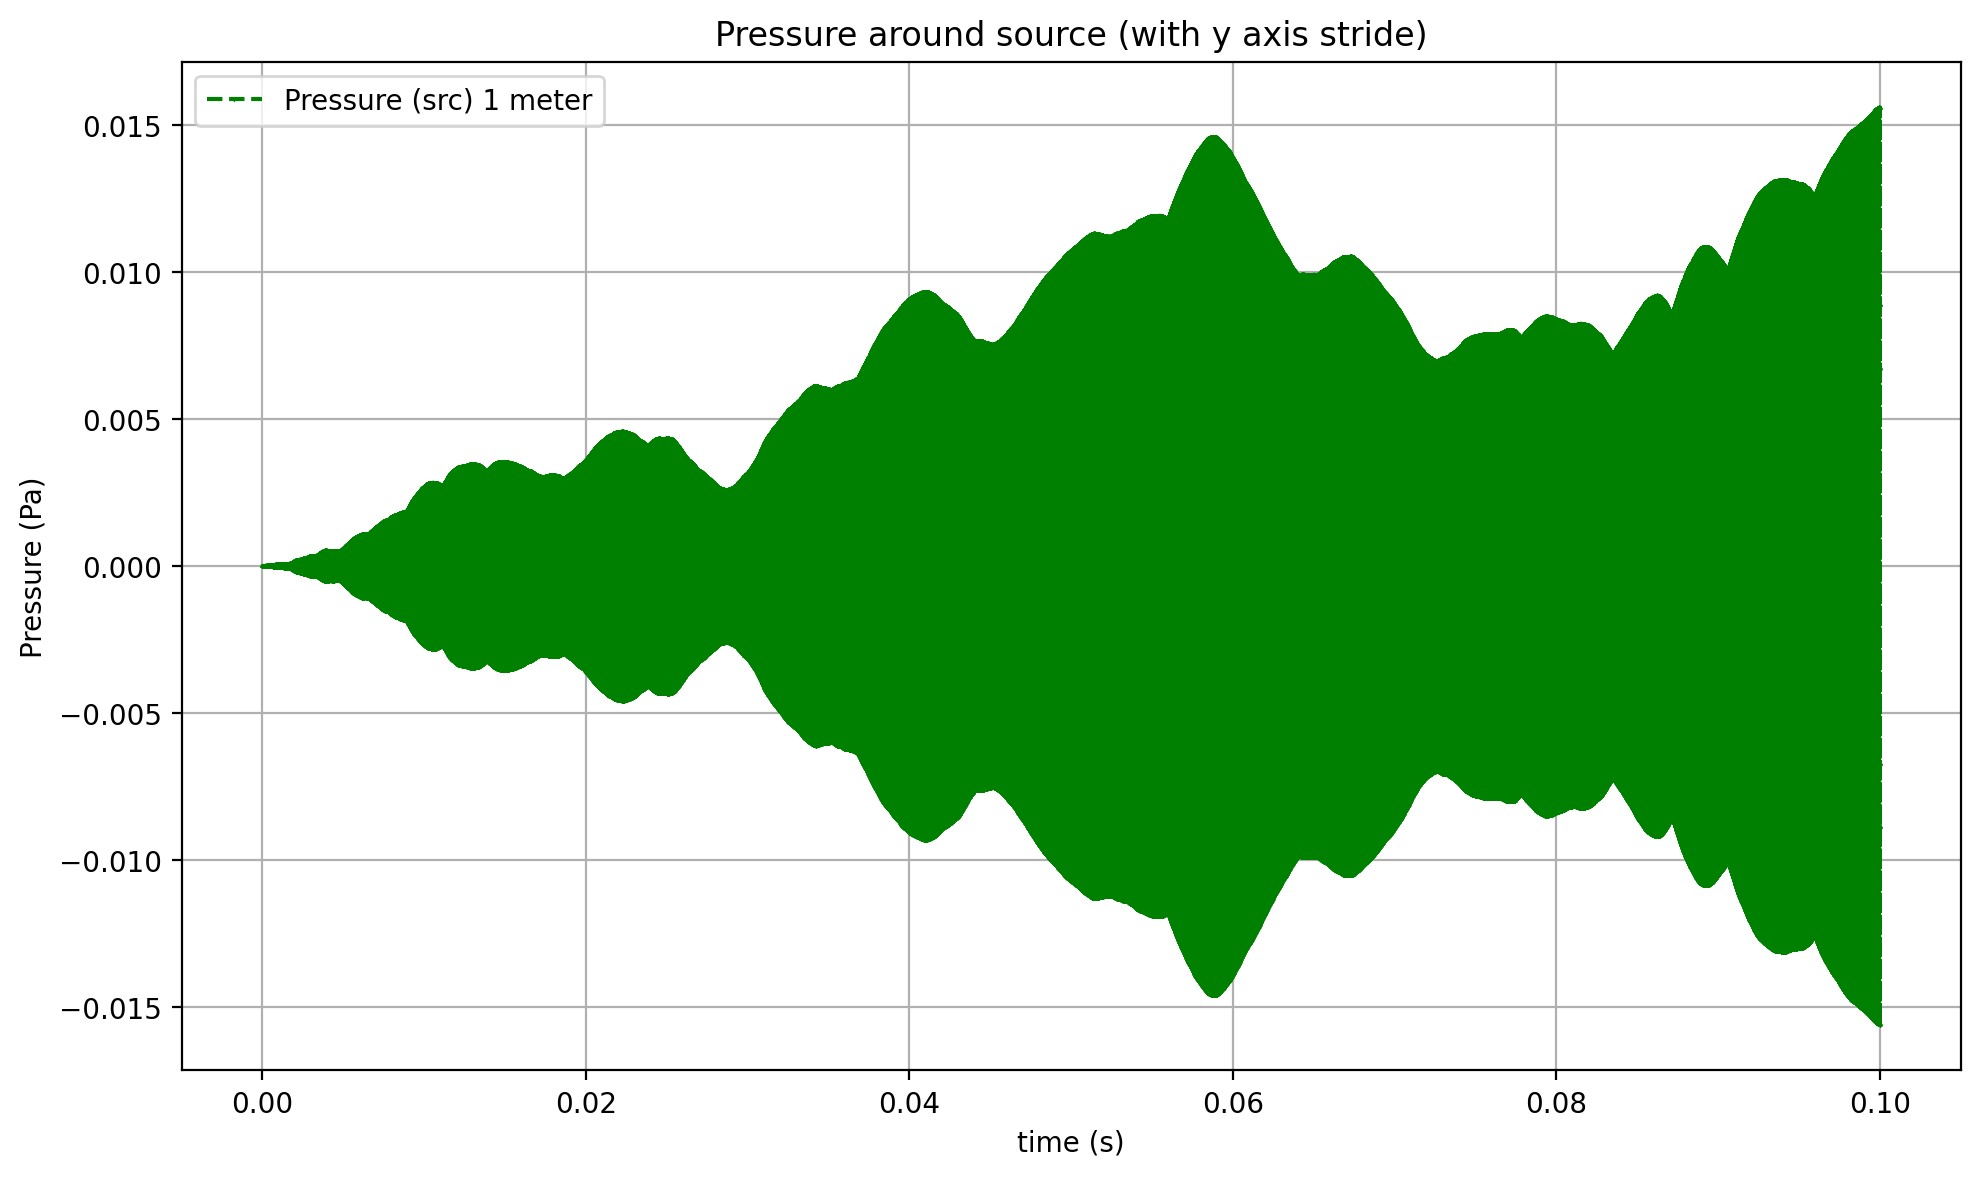

In [31]:
plt.figure(figsize=(10, 6))
# plt.plot(time_mesh.mesh, ps[0], label="Pressure (src)", color="red", linestyle="-", marker="o", ms=1)
plt.plot(time_mesh.mesh, ps[1], label="Pressure (src) 1 meter", color="green", linestyle="--", marker="*", ms=1)
# plt.plot(time_mesh.mesh[:250], ps[2][:250], label="Pressure (src) 2 meters", color="blue", linestyle="-", marker=".", ms=1)

# Add labels and title
plt.xlabel("time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure around source (with y axis stride)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()